In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# The gravitational constant G
G = 6.67428e-11
AU = (149.6e6 * 1000)     # 149.6 million km, in meters.

## Example: Planetary Motion in the Solar System
Today we will integrate the orbits of planets in the solar system interacting through gravity.

In general, the gravitational force on object $j$ with mass $m_j$ and position $\vec{r}_j$ through its gravitational interaction with objects $i$ with mass $m_i$ and position $\vec{x}_i$ is given by
$$
 \vec F_j = -\sum_{i\ne j}\frac{G m_j m_i}{|\vec x_i - \vec x_j|^2} \times \frac{\left(\vec x_i - \vec x_j\right)}{|\vec x_i - \vec x_j|}= m_j \vec a_j \tag{1}\label{FG}\,
$$
with the unit vector $\hat{\vec{x}} = \frac{\vec{x}}{|x|}$. _Note the direction of this force, gravity should pull two particles closer to each other! If that's not the case in your implementation, this is a good point to start..._

Here are approximate initial values for the inner four planets [(ref)](https://www.cs.princeton.edu/courses/archive/fall16/cos126/assignments/nbody.html)

Name |$p_x$ [m]|$p_y$ [m]|$v_x$ [m/s]| $v_y$ [m/s]| mass [kg]|
---- | ---- | ---- |---- | ----| ----| 
Sun | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 | 0.0000e+00 | 1.9890e+30
Mercury | 5.7900e+10 | 0.0000e+00 | 0.0000e+00 | 4.7900e+04 | 3.3020e+23 
Venus | 1.0820e+11 | 0.0000e+00 | 0.0000e+00 | 3.5000e+04 | 4.8690e+24
Earth| 1.4960e+11 | 0.0000e+00 | 0.0000e+00 | 2.9800e+04 | 5.9740e+24
Mars | 2.2790e+11 | 0.0000e+00 | 0.0000e+00 | 2.4100e+04 | 6.4190e+23     

Even in this simple case, passing different vectors when integrating the equation of motion would turn out to be cumbersome. To make keeping track of different data easier, we will use __Classes__ today.

We discussed Classes last week (`Week4/Python_OOP.ipynb`), but as a brief recap: Classes are a way of grouping related bits of information together into a single unit (also known as an object), along with functions that can be called to manipulate that object (also known as methods). For example, if you want to track information about a solar system body, you might want to record its name, mass, position, etc., and be able to manipulate all of these as a single unit.

Before we start, it's important to understand the difference between a class and an object. A class is simply a description of what things should look like, what variables will be grouped together, and what functions can be called to manipulate those variables. Using this description, Python can then create many instances of the class (or objects), which can then be manipulated independently. 

### Defining a Python Class

Let's start off by defining a simple class:

In [2]:
class Foo (object):
    def __init__(self, val):
        self.val = val
    def printVal(self):
        print(self.val)

The class is called Foo and as usual, we use indentation to tell Python where the class definition starts and ends. In this example, the class definition consists of two function definitions (or methods), one called ``__init__`` and the other ``printVal``. There is also one member variable, not explicitly defined, but we'll explain below how it gets created. Using this definition, we can then create many instances of the class.

Both methods take a parameter called self. It doesn't have to be called self but this is the Python convention. Because we can create many instances of a class, when a class method is called, it needs to know which instance it is working with, and that's what Python will pass in via the self parameter.

``__init__`` is a special method that is called whenever Python creates a new instance of the class. In our example, it accepts one parameter (other than the mandatory self), called ``val``, and takes a copy of it in a member variable, also called ``val``.  To differentiate between the val variable that was passed in as a parameter and the ``val`` class member variable, we prefix the latter with ``self``. So, in the statement

``self.val = val``

``self.val`` refers to the ``val`` member variable belonging to the class instance the method is being called for, while ``val`` refers to the parameter that was passed into the method.

Let's take a look at a simple example:

In [3]:
obj1 = Foo(1)

This creates an instance of our class . Python automatically calls the ``__init__`` method for us, passing in the value we specified (1). 

Let's create another one:

In [4]:
obj2 = Foo(2)

Exactly the same thing happens, except that 2 gets passed in to the ``__init__`` method.
We now have two independent objects, with different values for the ``val`` member variable.

Here's a class ``Body`` that we'll use for solar system bodies in today's Problem:

In [1]:
class Body(object):
    """Class representing a gravitationally-acting body, attributes for vVerlet integration

    Attributes:
        name : name of the body
        mass : mass in kg
        vx, vy: x, y velocities in m/s
        px, py: x, y positions in m
        ax, ay: acceleration 
        color: python color name (for plotting)
    """
    def __init__(self):
        self.name = 'Body'
        self.mass = None
        self.vx = self.vy = 0.0
        self.px = self.py = 0.0
        self.ax = self.ay = 0.0
    def pairwise_attraction(self, other):
        """(Body): (Fx, Fy)

        Returns the force exerted upon this body by the other body.
        """
        # Report an error if the other object is the same as this one.
        if self is other:
            raise ValueError("Attraction of object %r to itself requested"
                             % self.name)

        # Compute the distance of the other body.
        r = np.array([other.px-self.px,other.py-self.py])
        rr = np.sum(r*r)
        rhat = r/np.sqrt(rr)
        # Report an error if the distance is zero; otherwise we'll
        # get a ZeroDivisionError exception further down.
        if rr == 0:
            raise ValueError("Collision between objects %r and %r"
                             % (self.name, other.name))

        # Compute the force of attraction, Eq. 1
        # this is a numpy array consisting of [F_x,F_y]
        F = G * self.mass * other.mass / rr *rhat
        return F[0], F[1]

Let's create a few example instances already:

In [13]:
    sun = Body()
    sun.name = 'Sun'
    sun.color = 'red'
    sun.mass = 1.9890e+30

    earth = Body()
    earth.name = 'Earth'
    earth.color = 'blue'
    earth.mass = 5.9740e+24
    earth.px = 1.4960e+11
    earth.vy = 2.9800e+04

    venus = Body()
    venus.name = 'Venus'
    venus.color = 'yellow'
    venus.mass = 4.8685 * 10**24
    venus.px = 1.0820e+11
    venus.vy = 3.5000e+04

In [7]:
def set_acceleration(bodies):
    for body in bodies:
    # Add up all of the forces exerted on 'body'.
        total_fx = total_fy = 0.0
        for other in bodies:
            # Don't calculate the body's attraction to itself
            if body is other:
                continue
            fx, fy = body.pairwise_attraction(other)
            total_fx += fx
            total_fy += fy
        body.ax = total_fx/body.mass
        body.ay = total_fy/body.mass

In [8]:
def copy_acceleration(bodies):
    """Return a dictionary with current acceleration values for all bodies
    Parameter:
    bodies: list of Body instances
    
    Returns:
    a_current: dictonary, with a_current[body] = (body.ax,body.ay)
    """
    a_current ={}
    for body in bodies:
        a_current[body] = (body.ax, body.ay)
    return a_current


We will integrate orbits using the __velocity form__ of the Verlet algorithm
\begin{align}
x_{n+1} &= x_n + v_n\delta t + {1\over 2}a_n h^2 + \mathcal{O}(h^3) \tag{2a}\\
a_{n+1} &= a(x_{n+1}) \label{eq:Vv}\tag{2b}\\
v_{n+1} &= v_n + {1\over 2}\left(a_n + a_{n+1}\right)h + \mathcal{O}(h^2).\tag{2c}
\end{align}


In [9]:
def vVerlet_Step(bodies,h):
    
    #implement velocity Verlet step here
        
    #copy the current acceleration of all bodies into dictionary a_current
    #to access the x-acceleration of body: a_current[body][0]
    #to access the y-acceleration of body: a_current[body][1]
    a_current = copy_acceleration(bodies)
        
    #advance position (Equation 2a)

    #now update acceleration based on new position (Equation 2b)
    
    #now body.ax/y contains acceleration based on updated position
    #next, advance velocities (Equation 2c)


In [10]:
def loop(bodies,years):
    """([Body])

    loops through the simulation, updating the
    positions of all the provided bodies.
    """
    h = 24*3600  # One day
    steps = years*365
    trajectories = np.zeros((len(bodies),steps,2))
    for n, body in enumerate(bodies):
        trajectories[n,0] = np.array([body.px,body.py])/AU

    #initialize acceleration
    set_acceleration(bodies)
    #acceleration base on current (initial) position in now in body.ax/y
    for day in range(1,steps):
        #take one Verlet step
        vVerlet_Step(bodies,h)
        
        #save current configuration for visualization
        for n, body in enumerate(bodies):
            trajectories[n,day] = np.array([body.px,body.py])/AU

    #visualize the trajectories
    for n, body in enumerate(bodies):
        print("%r shown in %r"%(body.name,body.color))
        plt.plot(trajectories[n,::10,0],trajectories[n,::10,1],color=body.color,marker = 'x',markersize = 2.5)
    plt.xlabel("x [AU]")
    plt.ylabel("y [AU]")
    plt.show()

def main(years = 1):

    bodies =[sun,earth,venus]
    loop(bodies,years)


'Sun' shown in 'red'
'Earth' shown in 'blue'
'Venus' shown in 'yellow'


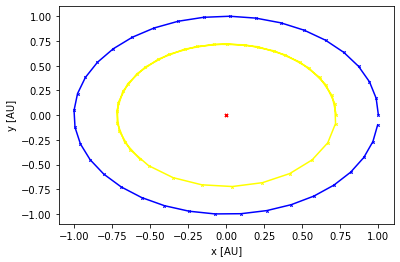

In [11]:
main()

<span style="color:blue"> If you like, you can add the Mars and Mercury!</span>